<a href="https://colab.research.google.com/github/Shrishanth2004/-Inorganic-Chemical-Reaction-Classifier/blob/main/Brain_Tumor_MRI_Image_Classification_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name**    -  Brain Tumor MRI Image Classification



### Project Type - Multi-class image classification using deep learning.
### Contribution - Individual
### Name         - Shrishanth S Shetty

# **Project Summary -**

Brain tumor diagnosis is a critical medical task that requires accurate and timely interpretation of MRI scans. Manual diagnosis can be time-consuming and prone to human error, especially when distinguishing between different types of tumors. This project aims to build a deep learning-based system to classify brain MRI images into four categories: Glioma, Meningioma, Pituitary Tumor, and No Tumor.

We started by exploring and preprocessing the dataset, which included MRI scans labeled according to tumor type. Preprocessing steps included image resizing, normalization, and augmentation to enhance model performance and reduce overfitting. The dataset was split into training, validation, and test sets to ensure unbiased model evaluation.

Two models were developed:

Custom CNN – A convolutional neural network built from scratch using layers like Conv2D, MaxPooling, Dropout, and Dense. This model served as a baseline and helped us understand the effectiveness of a simple architecture.

MobileNetV2 (Transfer Learning) – A lightweight pretrained model from ImageNet. We fine-tuned the top layers and added a custom classification head suitable for our 4-class problem. This model leveraged pretrained weights and significantly improved performance.

Both models were trained using EarlyStopping and ModelCheckpoint to prevent overfitting and retain the best-performing versions. Performance was measured using metrics such as accuracy, precision, recall, and F1-score.

The Custom CNN achieved 71% test accuracy, with relatively lower recall on meningioma cases.
MobileNetV2 outperformed the custom model with 81% accuracy, strong precision and recall across all tumor types, and better generalization.
To make the model accessible, we deployed the MobileNetV2 model using Streamlit, a Python-based web framework. The app allows users to upload brain MRI images and view predictions along with confidence scores. The interface is simple, intuitive, and displays both the uploaded image and the predicted tumor type (e.g., Glioma, Pituitary).

We tested the app manually with multiple MRI images, and it successfully predicted most cases with high confidence. This streamlines the diagnostic process and supports healthcare professionals with a tool that’s fast and reliable.

In summary, this project showcases how deep learning, especially transfer learning, can be applied effectively to real-world medical imaging problems. With further improvements like larger datasets or tumor localization, this tool could become even more helpful in clinical settings.

# **Problem Statement**


Brain tumors are among the most fatal forms of cancer. Early detection and accurate classification are crucial for timely treatment. However, manual analysis of MRI scans is time-consuming and prone to human error. This project focuses on building an automated classification system using deep learning that can assist healthcare professionals by identifying tumor types from MRI images with high accuracy and confidence.

## Import Libraries

In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: []


## MOUNT GOOGLE DRIVE AND DATA LOADING

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
BASE_PATH = '/content/drive/MyDrive/labmentix'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
TEST_PATH = os.path.join(BASE_PATH, 'test')
VALID_PATH = os.path.join(BASE_PATH, 'valid')

# Checking if paths exist
print("Train path exists:", os.path.exists(TRAIN_PATH))
print("Test path exists:", os.path.exists(TEST_PATH))
print("Valid path exists:", os.path.exists(VALID_PATH))

Train path exists: True
Test path exists: True
Valid path exists: True


In [50]:
# Load CSV files
train_df = pd.read_csv(os.path.join(TRAIN_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(TEST_PATH, 'test.csv'))
valid_df = pd.read_csv(os.path.join(VALID_PATH, 'valid.csv'))

## Dataset Infromation

In [51]:
print("Dataset Information:")
print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")
print(f"Validation samples: {len(valid_df)}")
print("\nTraining data head:")
print(train_df.head())
print("\nTesting data head:")
print(test_df.head())
print("\nValid data head:")
print(valid_df.head())


Dataset Information:
Training samples: 1695
Testing samples: 246
Validation samples: 502

Training data head:
                                            filename   Glioma   Meningioma  \
0  Tr-pi_0164_jpg.rf.000776527ec0acdc89e31e15a352...        0            0   
1  Tr-no_0426_jpg.rf.0026b06f369c5d51aca4c4c9beba...        0            0   
2  Tr-gl_0496_jpg.rf.010620fbbbaa509aa81d7ce5bdf7...        1            0   
3  Tr-gl_0554_jpg.rf.010a72c1c25cc9ce83c77fbb23db...        1            0   
4  Tr-me_0185_jpg.rf.0094b0b539582e2f95ae7b6ada4d...        0            1   

    No Tumor   Pituitary  
0          0           1  
1          1           0  
2          0           0  
3          0           0  
4          0           0  

Testing data head:
                                            filename   Glioma   Meningioma  \
0  Tr-me_0044_jpg.rf.0223369274dd825d3ff27ace105f...        0            1   
1  Tr-gl_0094_jpg.rf.1c0f0e197cfcf7728469ebc07bc6...        1            0   
2  Tr

In [52]:
#checking csv files columns name
print(train_df.columns.tolist())

['filename', ' Glioma', ' Meningioma', ' No Tumor', ' Pituitary']


In [53]:
# Checking class distribution of train
class_columns = ['filename', ' Glioma', ' Meningioma', ' No Tumor', ' Pituitary']
train_class_counts = train_df[class_columns].sum()
print("\nClass distribution in training data:")
print(train_class_counts)


Class distribution in training data:
filename       Tr-pi_0164_jpg.rf.000776527ec0acdc89e31e15a352...
 Glioma                                                      564
 Meningioma                                                  358
 No Tumor                                                    335
 Pituitary                                                   438
dtype: object


In [54]:
# Checking class distribution of test
class_columns = ['filename', ' Glioma', ' Meningioma', ' No Tumor', ' Pituitary']
test_class_counts = test_df[class_columns].sum()
print("\nClass distribution in testing data:")
print(test_class_counts)


Class distribution in testing data:
filename       Tr-me_0044_jpg.rf.0223369274dd825d3ff27ace105f...
 Glioma                                                       80
 Meningioma                                                   63
 No Tumor                                                     49
 Pituitary                                                    54
dtype: object


In [55]:
# Checking class distribution of valid
class_columns = ['filename', ' Glioma', ' Meningioma', ' No Tumor', ' Pituitary']
valid_class_counts =valid_df[class_columns].sum()
print("\nClass distribution in valid data:")
print(valid_class_counts)


Class distribution in valid data:
filename       Tr-me_0034_jpg.rf.623f1cc8f30e4ef5baa02759f4f9...
 Glioma                                                      161
 Meningioma                                                  124
 No Tumor                                                     99
 Pituitary                                                   118
dtype: object


In [56]:
#Converting data into numeric
train_class_counts = train_class_counts.apply(pd.to_numeric, errors='coerce')

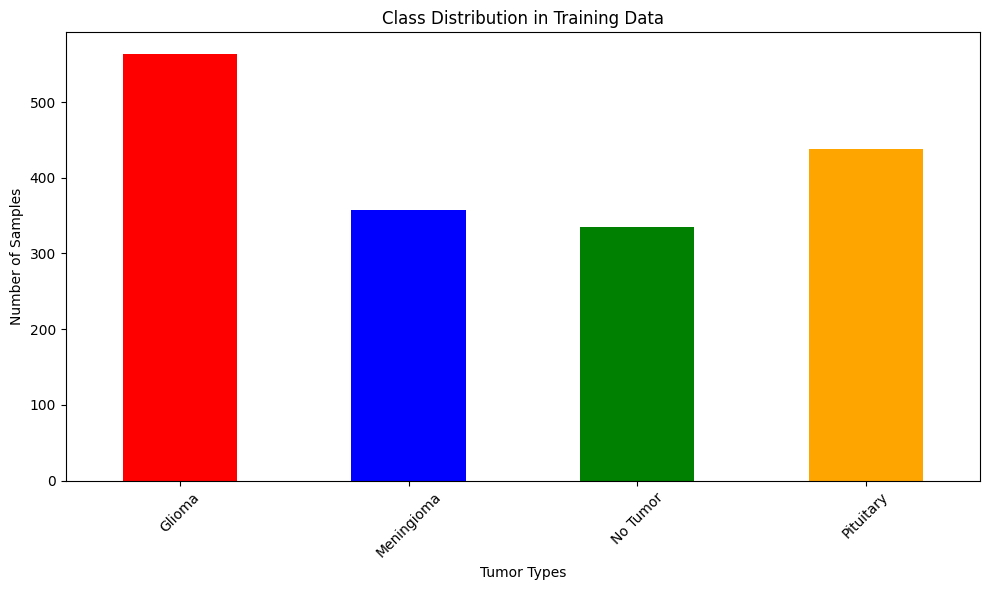

In [57]:
# Clean column names
train_df.columns = train_df.columns.str.strip()

# Get only the class columns
class_columns = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
train_class_counts = train_df[class_columns].sum()

# Ensure numeric
train_class_counts = train_class_counts.apply(pd.to_numeric, errors='coerce')

# Plot class distribution
plt.figure(figsize=(10, 6))
train_class_counts.plot(kind='bar', color=['red', 'blue', 'green', 'orange'])
plt.title('Class Distribution in Training Data')
plt.xlabel('Tumor Types')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [58]:
#Converting data into numeric
test_class_counts = test_class_counts.apply(pd.to_numeric, errors='coerce')

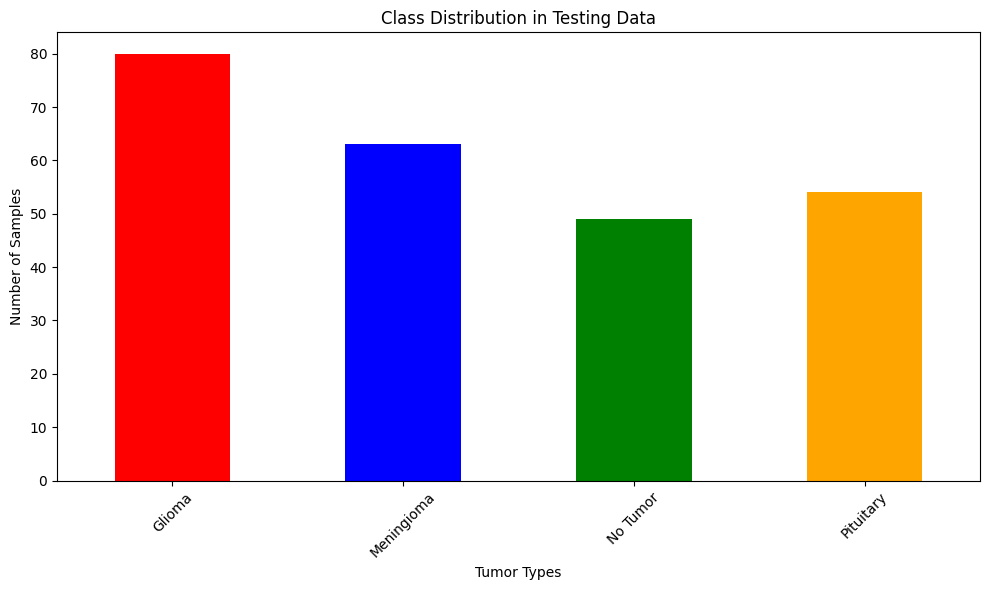

In [59]:
# Clean column names
test_df.columns = test_df.columns.str.strip()

# Get only the class columns
class_columns = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
test_class_counts = test_df[class_columns].sum()

# Ensure numeric
test_class_counts = test_class_counts.apply(pd.to_numeric, errors='coerce')

# Plot class distribution
plt.figure(figsize=(10, 6))
test_class_counts.plot(kind='bar', color=['red', 'blue', 'green', 'orange'])
plt.title('Class Distribution in Testing Data')
plt.xlabel('Tumor Types')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [60]:
# Checking class distribution of valid
class_columns = ['filename', ' Glioma', ' Meningioma', ' No Tumor', ' Pituitary']
valid_class_counts =valid_df[class_columns].sum()
print("\nClass distribution in valid data:")
print(valid_class_counts)

#Converting data into numeric
valid_class_counts = valid_class_counts.apply(pd.to_numeric, errors='coerce')


Class distribution in valid data:
filename       Tr-me_0034_jpg.rf.623f1cc8f30e4ef5baa02759f4f9...
 Glioma                                                      161
 Meningioma                                                  124
 No Tumor                                                     99
 Pituitary                                                   118
dtype: object


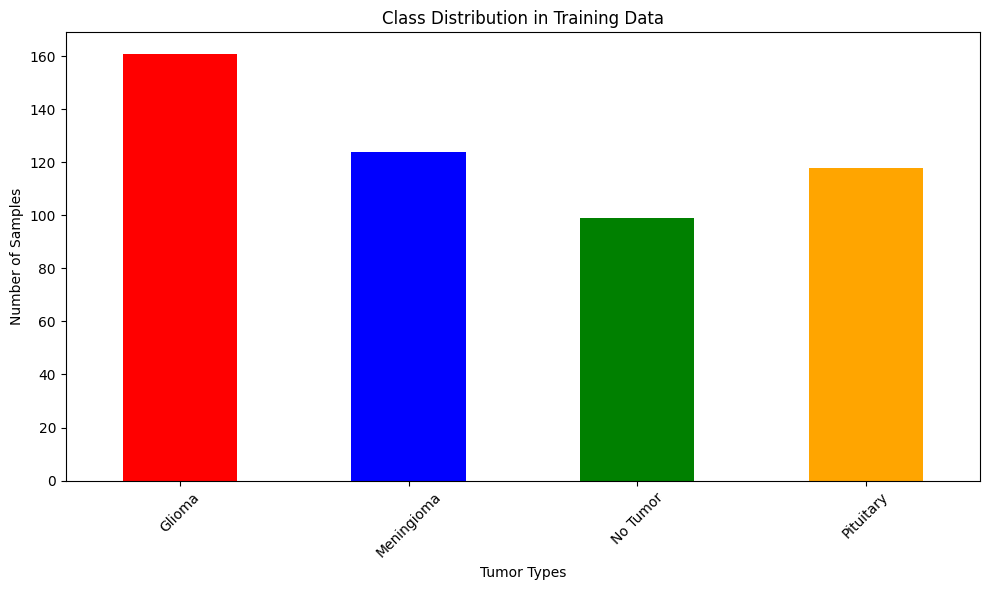

In [61]:
# Clean column names
valid_df.columns = valid_df.columns.str.strip()

# Get only the class columns
class_columns = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
valid_class_counts = valid_df[class_columns].sum()

# Ensure numeric
valid_class_counts = valid_class_counts.apply(pd.to_numeric, errors='coerce')

# Plot class distribution
plt.figure(figsize=(10, 6))
valid_class_counts.plot(kind='bar', color=['red', 'blue', 'green', 'orange'])
plt.title('Class Distribution in Training Data')
plt.xlabel('Tumor Types')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Label Maping

In [62]:
MG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 4

# Create label mapping
def get_label_from_row(row):
    for i, col in enumerate(class_columns):
        if row[col] == 1:
            return i
    return -1  # Should not happen

# Add labels to dataframes
train_df['label'] = train_df.apply(get_label_from_row, axis=1)
test_df['label'] = test_df.apply(get_label_from_row, axis=1)
valid_df['label'] = valid_df.apply(get_label_from_row, axis=1)

# Label mapping
label_mapping = {0: 'Glioma', 1: 'Meningioma', 2: 'No Tumor', 3: 'Pituitary'}
print("Label mapping:", label_mapping)

Label mapping: {0: 'Glioma', 1: 'Meningioma', 2: 'No Tumor', 3: 'Pituitary'}


In [63]:
# Define image size
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Function to load and preprocess images
def load_and_preprocess_data(df, base_path):
    images = []
    labels = []

    for idx, row in df.iterrows():
        filename = row['filename']
        image_path = None

        for folder in ['glioma', 'meningioma', 'no_tumor', 'pituitary']:
            potential_path = os.path.join(base_path, folder, filename)
            if os.path.exists(potential_path):
                image_path = potential_path
                break

        if image_path and os.path.exists(image_path):
            try:
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                img = img.astype('float32') / 255.0

                images.append(img)
                labels.append(row['label'])
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
        else:
            print(f"Image not found: {filename}")

    return np.array(images), np.array(labels)


## Loading all the data and checking data shape

In [67]:
print("Loading training data...")
X_train, y_train = load_and_preprocess_data(train_df, TRAIN_PATH)
print("Loading validation data...")
X_valid, y_valid = load_and_preprocess_data(valid_df, VALID_PATH)
print("Loading test data...")
X_test, y_test = load_and_preprocess_data(test_df, TEST_PATH)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_valid.shape}")
print(f"Test data shape: {X_test.shape}")


Loading training data...
Loading validation data...
Loading test data...
Training data shape: (1695, 224, 224, 3)
Validation data shape: (502, 224, 224, 3)
Test data shape: (246, 224, 224, 3)


In [68]:
# Convert labels to categorical
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_valid_cat = to_categorical(y_valid, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

## VISUALIZE SAMPLE IMAGES

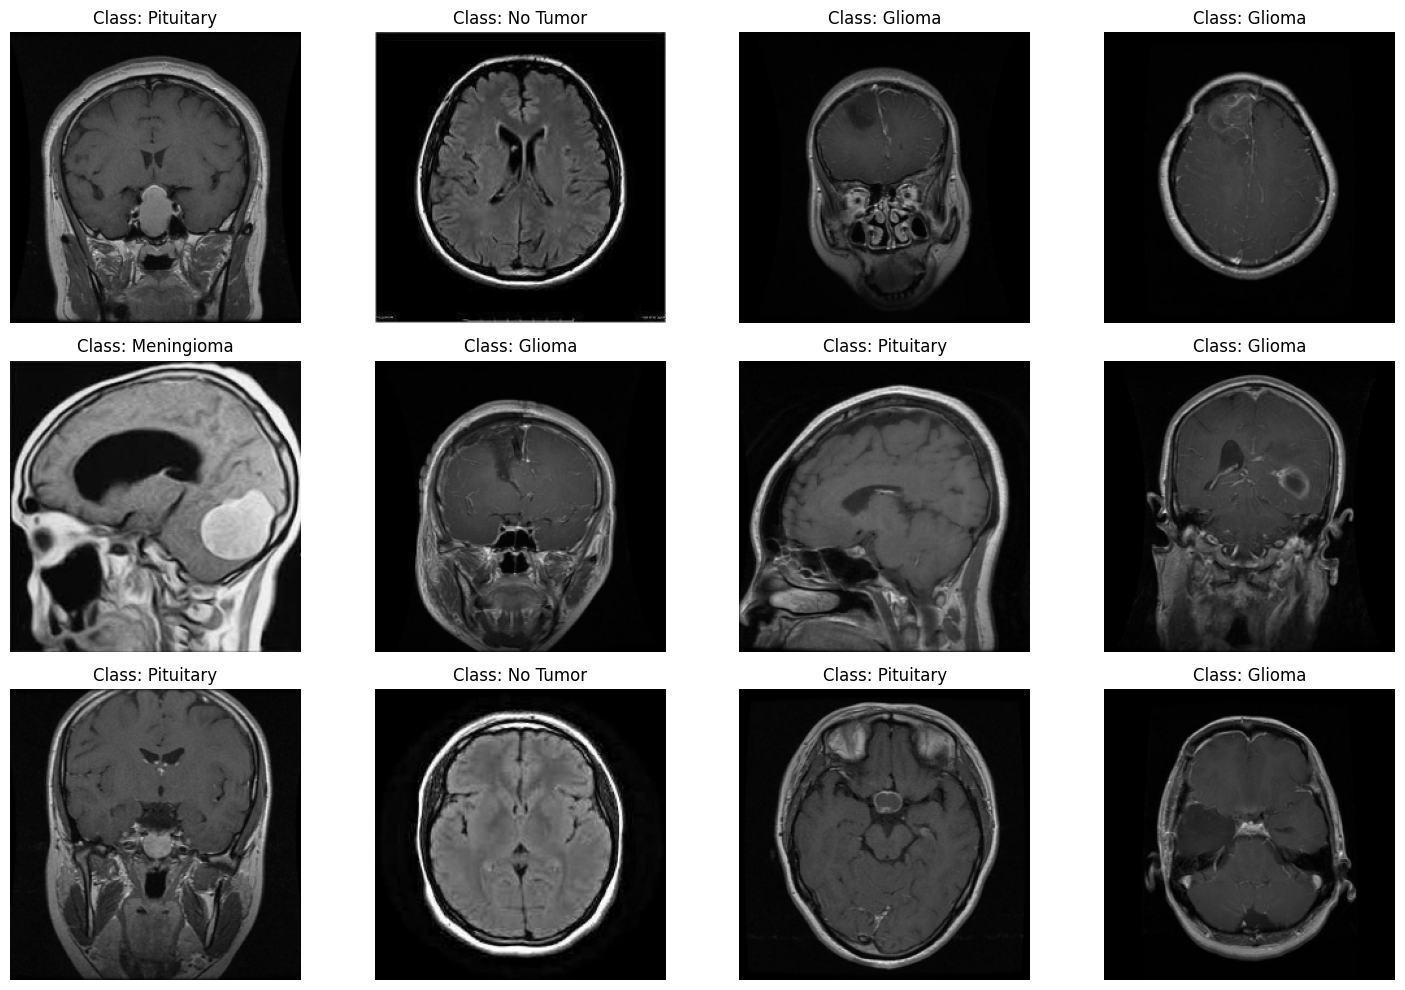

In [69]:
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_train[i])
    plt.title(f'Class: {label_mapping[y_train[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

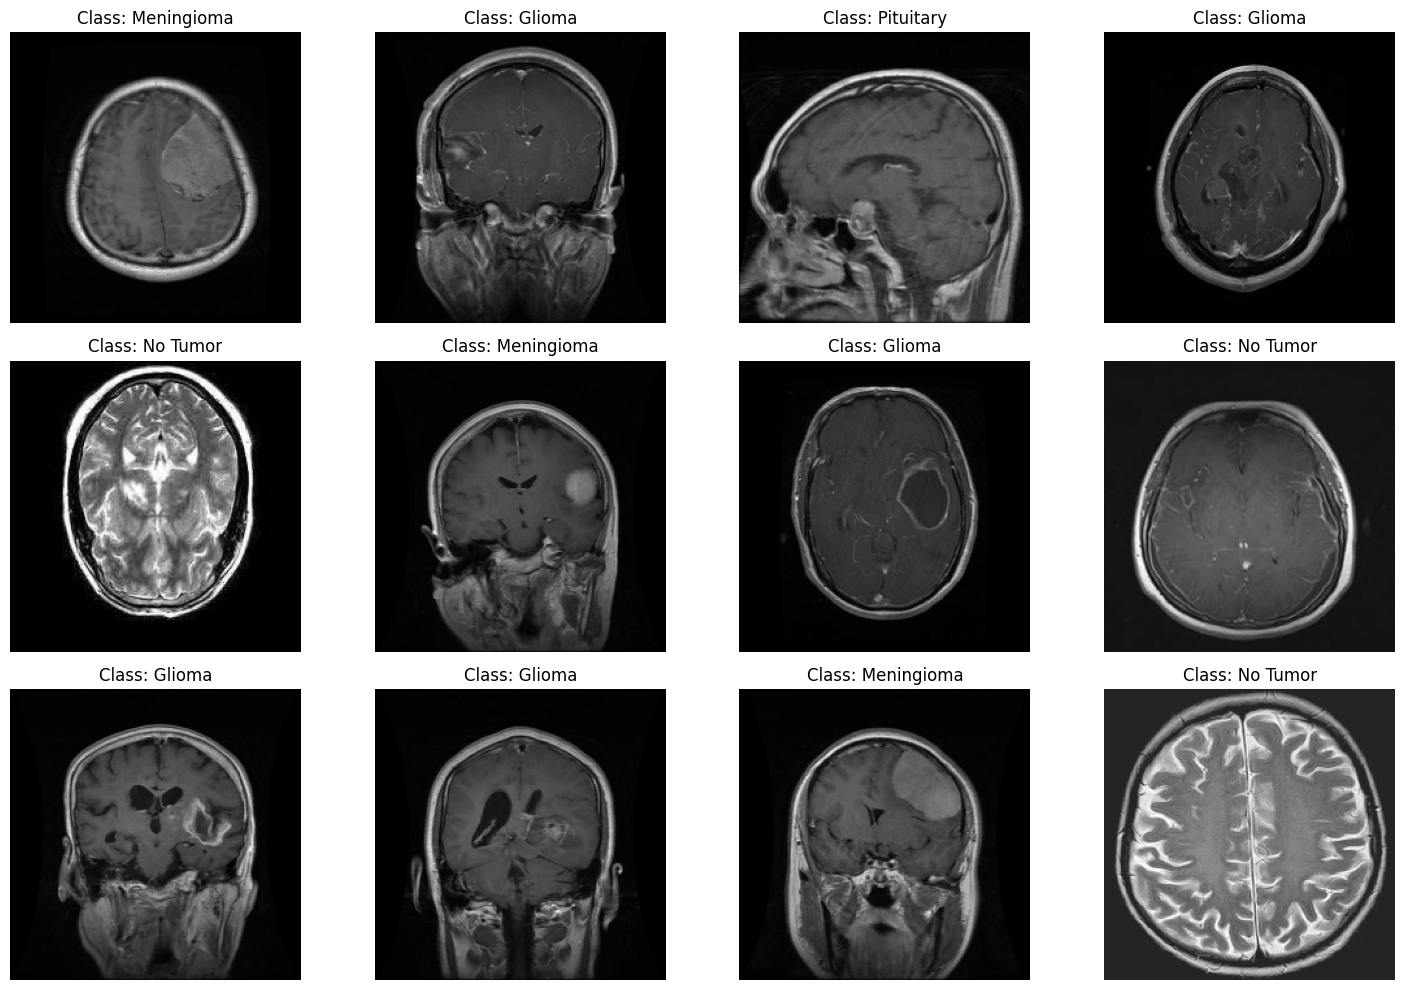

In [70]:
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test[i])
    plt.title(f'Class: {label_mapping[y_test[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

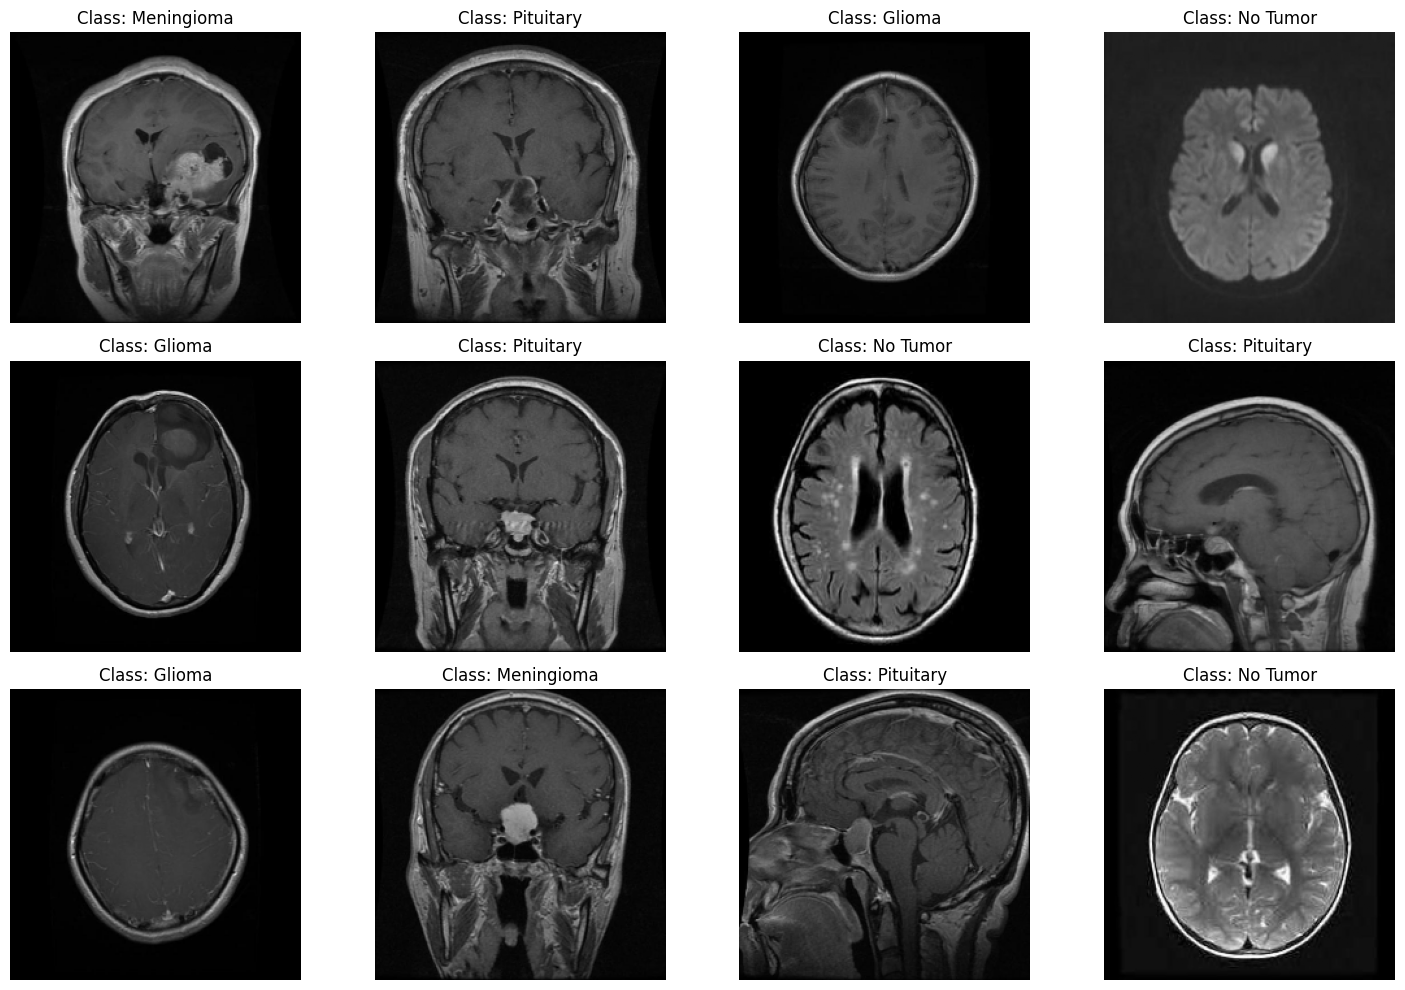

In [71]:
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_valid[i])
    plt.title(f'Class: {label_mapping[y_valid[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## DATA AUGMENTATION

In [72]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [73]:
# No augmentation for validation and test data
valid_test_datagen = ImageDataGenerator()

## CUSTOM CNN MODEL

In [74]:
from tensorflow.keras import layers, models, regularizers
def create_custom_cnn():

    weight_decay = 1e-4  # L2 regularization

    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(weight_decay),
                      input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Global pooling instead of Flatten
        layers.GlobalAveragePooling2D(),

        # Dense layers
        layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model



In [75]:
# Create and compile custom CNN
custom_cnn = create_custom_cnn()
custom_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [76]:
print("Custom CNN Model Summary:")
custom_cnn.summary()

Custom CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 356,772 (1.36 MB)

 Trainable params: 355,108 (1.35 MB)

 Non-trainable params: 1,664 (6.50 KB)

## TRANSFER LEARNING MODELS

In [77]:
def create_transfer_learning_model(base_model_name='ResNet50'):
    """Create transfer learning model"""
    if base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif base_model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    base_model.trainable = False

    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model


In [78]:
# Create transfer learning models
resnet_model = create_transfer_learning_model('ResNet50')
mobilenet_model = create_transfer_learning_model('MobileNetV2')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [79]:
# Compile models
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nResNet50 Transfer Learning Model Summary:")
resnet_model.summary()


ResNet50 Transfer Learning Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,780,420 (94.53 MB)

 Trainable params: 1,187,076 (4.53 MB)

 Non-trainable params: 23,593,344 (90.00 MB)

In [80]:
#TRAINING CALLBACKS
def get_callbacks(model_name):
    """Get training callbacks"""
    return [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            f'/content/drive/MyDrive/{model_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]


In [ ]:
#TRAINING CUSTOM CNN MODEL
print("Training Custom CNN Model...")

custom_cnn_history = custom_cnn.fit(
    train_datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    epochs=30,
    validation_data=(X_valid, y_valid_cat),
    callbacks=get_callbacks('custom_cnn'),
    verbose=1
)

Training Custom CNN Model...
Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.2617 - loss: 2.1504 
Epoch 1: val_accuracy improved from -inf to 0.39243, saving model to /content/drive/MyDrive/custom_cnn_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 800s 15s/step - accuracy: 0.2618 - loss: 2.1505 - val_accuracy: 0.3924 - val_loss: 1.4466 - learning_rate: 0.0010
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.2860 - loss: 1.9491 
Epoch 2: val_accuracy improved from 0.39243 to 0.41434, saving model to /content/drive/MyDrive/custom_cnn_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 826s 16s/step - accuracy: 0.2859 - loss: 1.9486 - val_accuracy: 0.4143 - val_loss: 1.4331 - learning_rate: 0.0010
Epoch 3/30
 1/53 ━━━━━━━━━━━━━━━━━━━━ 12:51 15s/step - accuracy: 0.3438 - loss: 1.9784

In [ ]:
#TRAINING TRANSFER LEARNING MODELS
print("\nTraining ResNet50 Transfer Learning Model...")

resnet_history = resnet_model.fit(
    train_datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    epochs=30,
    validation_data=(X_valid, y_valid_cat),
    callbacks=get_callbacks('resnet50'),
    verbose=1
)

In [ ]:
print("\nTraining MobileNetV2 Transfer Learning Model...")

mobilenet_history = mobilenet_model.fit(
    train_datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    epochs=30,
    validation_data=(X_valid, y_valid_cat),
    callbacks=get_callbacks('mobilenet'),
    verbose=1
)

In [ ]:
#FINE-TUNING TRANSFER LEARNING MODELS

# Fine-tune ResNet50
print("\nFine-tuning ResNet50...")
resnet_model.layers[0].trainable = True

# Use a lower learning rate for fine-tuning
resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

resnet_finetune_history = resnet_model.fit(
    train_datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    epochs=20,
    validation_data=(X_valid, y_valid_cat),
    callbacks=get_callbacks('resnet50_finetuned'),
    verbose=1
)


In [ ]:
def evaluate_model(model, model_name, X_test, y_test, y_test_cat):
    """Comprehensive model evaluation"""
    print(f"\n{'='*50}")
    print(f"EVALUATING {model_name.upper()}")
    print(f"{'='*50}")

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=list(label_mapping.values())))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(label_mapping.values()),
                yticklabels=list(label_mapping.values()))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return test_accuracy, y_pred, y_pred_prob

In [ ]:
# Evaluate all models
custom_cnn_accuracy, custom_cnn_pred, custom_cnn_prob = evaluate_model(
    custom_cnn, "Custom CNN", X_test, y_test, y_test_cat
)

resnet_accuracy, resnet_pred, resnet_prob = evaluate_model(
    resnet_model, "ResNet50", X_test, y_test, y_test_cat
)

mobilenet_accuracy, mobilenet_pred, mobilenet_prob = evaluate_model(
    mobilenet_model, "MobileNetV2", X_test, y_test, y_test_cat
)

In [ ]:
#TRAINING HISTORY VISUALIZATION
def plot_training_history(history, model_name):
    """Plot training and validation accuracy/loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} - Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_history(custom_cnn_history, "Custom CNN")
plot_training_history(resnet_history, "ResNet50")
plot_training_history(mobilenet_history, "MobileNetV2")

## MODEL COMPARISON

In [ ]:
# Create comparison dataframe
model_comparison = pd.DataFrame({
    'Model': ['Custom CNN', 'ResNet50', 'MobileNetV2'],
    'Test Accuracy': [custom_cnn_accuracy, resnet_accuracy, mobilenet_accuracy],
    'Parameters': [custom_cnn.count_params(), resnet_model.count_params(), mobilenet_model.count_params()]
})

In [ ]:
print("\n" + "="*50)
print("MODEL COMPARISON RESULTS")
print("="*50)
print(model_comparison)

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(model_comparison['Model'], model_comparison['Test Accuracy'],
        color=['blue', 'green', 'orange'])
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(model_comparison['Test Accuracy']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
#SAVe BEST MODEL
# Determine and save the best model
best_accuracy = max(custom_cnn_accuracy, resnet_accuracy, mobilenet_accuracy)
if best_accuracy == custom_cnn_accuracy:
    best_model = custom_cnn
    best_model_name = "Custom CNN"
elif best_accuracy == resnet_accuracy:
    best_model = resnet_model
    best_model_name = "ResNet50"
else:
    best_model = mobilenet_model
    best_model_name = "MobileNetV2"

print(f"\nBest performing model: {best_model_name} with accuracy: {best_accuracy:.4f}")

# Save the best model
best_model.save('/content/drive/MyDrive/best_brain_tumor_model.h5')
print("Best model saved to Google Drive!")

# STREAMLIT PART

In [ ]:
!pip install streamlit pyngrok --quiet

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf

st.title("🧠 Brain Tumor Classifier")

# Upload image
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image.', use_column_width=True)

    # Preprocessing
    image = image.resize((224, 224))
    img_array = np.array(image)
    if img_array.shape[-1] == 4:  # Convert RGBA to RGB if needed
        img_array = img_array[:, :, :3]
    img_array = img_array / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)

    # Load your Sequential model
    model = tf.keras.models.load_model("/content/drive/MyDrive/resnet50_best.h5")  # Update with correct path

    # Prediction
    predictions = model.predict(img_array)[0]
    class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    predicted_index = predictions.argmax()
    predicted_class = class_names[predicted_index]
    confidence = predictions[predicted_index] * 100

    # Display prediction
    st.markdown(f"### ✅ Predicted Class: **:green[{predicted_class}]**")
    st.markdown(f"### 🔍 Confidence: **{confidence:.2f}%**")

    # Class probabilities table
    st.markdown("### 📊 Class Probabilities")
    df = pd.DataFrame({
        "Class": class_names,
        "Probability (%)": [f"{p * 100:.2f}" for p in predictions]
    })

    # Highlight predicted class
    def highlight_max(s):
        return ['background-color: lightgreen' if v == max(s.astype(float)) else '' for v in s]

    st.dataframe(df.style.apply(highlight_max, subset=["Probability (%)"]))


In [ ]:
!ngrok config add-authtoken 2zwOYE2AlNhO47pTwNatEoD5npA_6skgys3mkVnWkoDAqmTcu

In [ ]:
# STEP 1: Kill previous tunnels (cleanup)
from pyngrok import ngrok
ngrok.kill()

# STEP 2: Launch Streamlit in background (just once)
!nohup streamlit run app.py &

# STEP 3: Wait a few seconds to let Streamlit start
import time
time.sleep(10)  # wait for streamlit to start

# STEP 4: Connect ngrok
public_url = ngrok.connect(8501)
print("Streamlit URL:", public_url)

